# Variational Autoencoder

In au autoencoder, the decoder samples directly from latent variables. Variational autoencoders (VAEs), differ in that the sampling is taken from a distribution parameterized by the latent variables

Gaussian distributions in VAEs are assumed to be i.i.d (identically and independently distributed) and therefore do not require covariance matrix to describe the correlation between the variables. As a result, we need just $n$ pairs of mean and variance to describe our multivariate Gaussian distribution.

This notebook is gonna show you application of variational autoencoder on image generation and image editing. Those 2 applications will set you up for more advanced technique in deep generative model such as GANs and so on. This notebook used 2 popular datasets, says MNIST and Celeb A.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Flatten, Reshape, Layer, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
(ds_train, ds_test_), ds_info = tfds.load('mnist',
                              split=['test', 'test'],
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)

#fig = tfds.show_examples(ds_info, ds_train)

batch_size = 256
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image

ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

## Construct Layer for MNIST

In [3]:
class GaussianSampling(Layer):
  def call(self, inputs):
    means, logvars = inputs
    epsilon = tf.random.normal(shape = tf.shape(means),
                               mean = 0., stddev = 1.)

    samples = means + tf.exp(0.5*logvars)*epsilon
    return samples

class Encoder(Layer):
  def __init__(self, z_dim, name = 'encoder'):
    super(Encoder, self).__init__()
    self.feature_extract = Sequential([
        Conv2D(filters = 8, kernel_size = (3,3), strides = 2, padding = 'same', activation = 'relu'),
        Conv2D(filters = 8, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
        Conv2D(filters = 8, kernel_size = (3,3), strides = 2, padding = 'same', activation = 'relu'),
        Conv2D(filters = 8, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
        Flatten()
    ])

    self.dense_means = Dense(z_dim, name = 'mean')
    self.dense_logvars = Dense(z_dim, name = 'logvar')
    self.sampling = GaussianSampling()

  def call(self, inputs):
    x = self.feature_extract(inputs)
    means = self.dense_means(x)
    logvars = self.dense_logvars(x)
    z = self.sampling((means, logvars))

    return z, means, logvars

class Decoder(Layer):
  def __init__(self, z_dim, name = 'decoder'):
    super(Decoder, self).__init__()
    self.decoder = Sequential([
        Input(shape = z_dim),
        Dense((7*7*64), activation = 'relu'),
        Reshape((7, 7, 64)),
        Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = "same", activation = 'relu'),
        UpSampling2D((2,2)),
        Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
        UpSampling2D((2,2)),
        Conv2D(filters = 1, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')
    ])
  def call(self, inputs):
    out = self.decoder(inputs)
    return out

class VAE(Model):
  def __init__(self, z_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
    self.means = None
    self.logvars = None

  def call(self, inputs):
    z, means, logvars = self.encoder(inputs)
    self.means = means
    self.logvars = logvars
    out = self.decoder(z)

    return out


## Loss function

We can now sample from a multivariate Gaussian distribution, but there is still no guarantee that the Gaussian blobs won't be far apart from each other and widely spread. The way VAEs do this is by putting in some regularization to encourange our Gaussian looks like $N(0, 1)$. This is done by __Kullback-Leibler divergence__

$$
D_{KL}(N(\mu| \sigma) || N(0,1)) = -0.5 \sum_{i=1}^{z\_dim} \log \sigma_i^2  - \sigma_i^2 - \mu_i^2 + 1
$$

In [4]:
vae = VAE(z_dim = 2)

def latent_loss(y_true, y_pred):
  kl_loss = -0.5 * tf.reduce_mean(vae.logvars - tf.exp(vae.logvars) - tf.square(vae.means) + 1)
  return kl_loss

def reconstruction_loss(y_true, y_pred):
  rc_loss = tf.keras.losses.MSE(y_true, y_pred)
  return rc_loss

def vae_loss(y_true, y_pred):
  kl_weight = 0.01
  kl_loss = latent_loss(vae.means, vae.logvars)
  rc_loss = reconstruction_loss(y_true, y_pred)
  vae_loss = kl_loss*kl_weight + rc_loss

  return vae_loss

In [ ]:
model_path = "./models/vae.h5"
os.makedirs("./models", exist_ok = True)

checkpoint = ModelCheckpoint(model_path,
                             monitor = "reconstruction_loss",
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_weights_only = True)

early = EarlyStopping(monitor = 'reconstruction_loss',
                      mode = 'auto',
                      patience = 10)

vae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
            loss = [vae_loss],
            metrics = [latent_loss, reconstruction_loss])

vae.fit(ds_train, validation_data = ds_test,
        epochs = 50, callbacks = [early, checkpoint])

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 0.0773 - latent_loss: 0.0034 - reconstruction_loss: 0.0772
Epoch 1: reconstruction_loss improved from inf to 0.07722, saving model to ./models/vae.h5
40/40 [==============================] - 21s 45ms/step - loss: 0.0773 - latent_loss: 0.0034 - reconstruction_loss: 0.0772 - val_loss: 0.0685 - val_latent_loss: 0.0011 - val_reconstruction_loss: 0.0685
Epoch 2/50
35/40 [=========================>....] - ETA: 0s - loss: 0.0680 - latent_loss: 0.0012 - reconstruction_loss: 0.0680
Epoch 2: reconstruction_loss improved from 0.07722 to 0.06794, saving model to ./models/vae.h5
40/40 [==============================] - 1s 14ms/step - loss: 0.0679 - latent_loss: 0.0012 - reconstruction_loss: 0.0679 - val_loss: 0.0677 - val_latent_loss: 0.0013 - val_reconstruction_loss: 0.0677
Epoch 3/50
36/40 [==========================>...] - ETA: 0s - loss: 0.0676 - latent_loss: 0.0025 - reconstruction_loss: 0.0676
Epoch 3: reconstruction_loss imp

# Display latent distribution and see how latent space reflect the hidden features

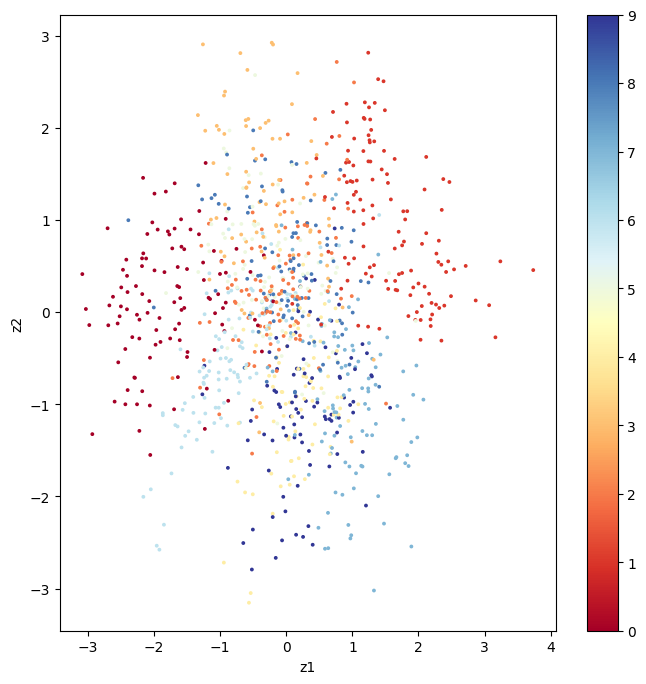

In [ ]:
vae.load_weights(model_path)

def preprocess_with_label(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.math.round(image / 255.)
  return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

images, labels = next(iter(ds_test_label))
outputs, means, logvars = vae.encoder(images)
plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.xlabel("z1")
plt.ylabel("z2")
plt.colorbar()


Compare to autoencoder (with specific latent variables), the distribution of outputs from encoder $(z = \mu + \sigma* \epsilon)$ seems to be more Gaussian-like and overlapped together. This phenomenon is caused by the latent loss via KL divergence which forces latent space to be closer to normality

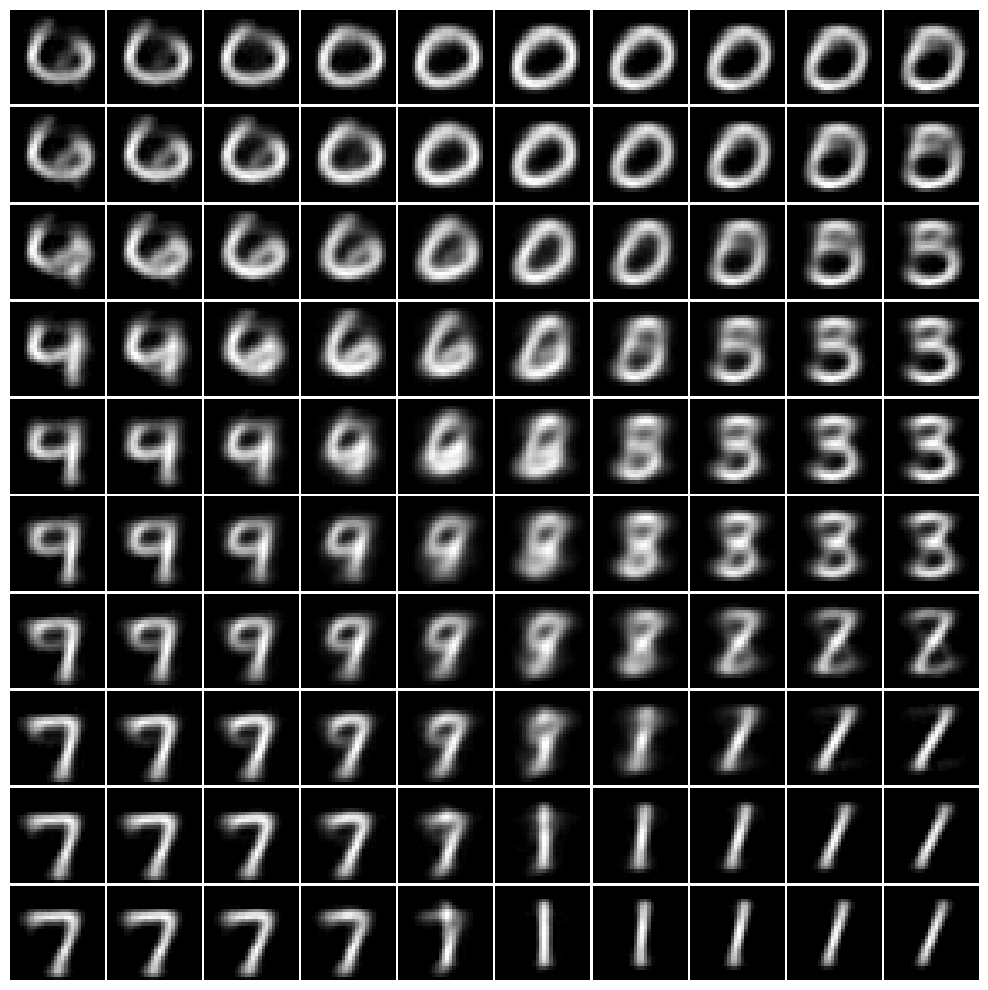

In [ ]:
z_samples = np.array([[z1, z2] for z1 in np.arange(-2.5, 2.5, 0.5) for z2 in np.arange(-2.5, 2.5, 0.5)])
images = vae.decoder(z_samples)

grid_col, grid_row = 10, 10
f, axarr = plt.subplots(grid_row, grid_col, figsize = (grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(h_pad=0.2, w_pad=0.1)
plt.show()

# Generating Faces with VAEs

In this section, we assume the dataset contains RGB images.

__Network architecture:__
- Reuse the MNIST VAE and training pipeline with some modifications given that the dataset is now different from MNIST.
- Increase the latent space dimension
- The input shape is changed from (28, 28, 1) to (112, 112, 3) as we now have 3 color channels instead of grayscale.
- Add image resizing in the pre-processing pipline.

__Note:__
- KL divergence is somehow regularization for reconstruction loss, in increase the diversity of images but reduce slightly their resolution
- In image generation, we are more interested in the reconstructed image's quality

## Load Celeb A dataset

In [33]:
# import gdown
# url = 'https://drive.google.com/uc?id=1tCj_CKUgjtThk1fiL0wP0WiuYxk4dvjT'
# tfds_rootdir = '/root/' # for Google Colab
# #tfds_rootdir = '~/' # for Linux

# file_path = os.path.join(tfds_rootdir, 'tensorflow_datasets/celeb_a.zip')
# file_dir = file_path.replace('.zip','')
# gdown.download(url, file_path, quiet=False)

# !unzip $file_path -d $file_dir

(ds_train, ds_test_), ds_info = tfds.load('celeb_a',
                              split=['train', 'test'],
                              shuffle_files=True,
                              with_info=True)

batch_size = 128

def preprocess(sample):
    image = sample['image']
    image = tf.image.resize(image, [112,112])
    image = tf.cast(image, tf.float32)/255.
    return image, image

ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(batch_size*4)
ds_train = ds_train.batch(batch_size).prefetch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).prefetch(batch_size)

train_num = ds_info.splits['train'].num_examples
test_num = ds_info.splits['test'].num_examples

## Construct Layers for face generation

In [6]:
class FaceEncoder(Layer):
  def __init__(self, z_dim, name = "encoder"):
    super(FaceEncoder, self).__init__()
    self.feature_extract = Sequential([
        Input(shape = (112, 112, 3)),
        Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
        Conv2D(filters = 64, kernel_size = (3,3), strides = 2, padding = 'same', activation = 'relu'),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
        Conv2D(filters = 96, kernel_size = (3,3), strides = 2, padding = "same", activation = 'relu'),
        BatchNormalization(),
        Conv2D(filters = 96, kernel_size = (3,3), strides = 1, padding = "same", activation = 'relu'),
        Conv2D(filters = 128, kernel_size = (3,3), strides = 2, padding = "same", activation = 'relu'),
        BatchNormalization(),
        Conv2D(filters = 128, kernel_size = (3,3), strides = 1, padding = "same", activation = 'relu'),
        Conv2D(filters = 128, kernel_size = (3,3), strides = 2, padding = "same", activation = 'relu'),
        BatchNormalization(),
        Flatten(),
    ])

    self.dense_means = Dense(z_dim, name = 'means')
    self.dense_logvars = Dense(z_dim, name = "logvars")
    self.sampler = GaussianSampling()

  def call(self, inputs):
    features = self.feature_extract(inputs)
    means = self.dense_means(features)
    logvars = self.dense_logvars(features)
    z = self.sampler((means, logvars))
    return z, means, logvars

class FaceDecoder(Layer):
  def __init__(self, z_dim, name = "decoder"):
    super(FaceDecoder, self).__init__()
    self.decoder = Sequential([
        Input(shape = (z_dim)),
        Dense(units = (7*7*128), activation = 'relu'),
        Reshape((7,7,128)),
        Conv2D(filters = 128, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
        UpSampling2D((2,2)),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
        UpSampling2D((2,2)),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
        UpSampling2D((2,2)),
        BatchNormalization(),
        Conv2D(filters = 16, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
        UpSampling2D((2,2)),
        BatchNormalization(),
        Conv2D(filters = 3, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')
    ])

  def call(self, inputs):
    out = self.decoder(inputs)
    return out

class FaceVAE(Model):
  def __init__(self, z_dim, name = 'face-vae'):
    super(FaceVAE, self).__init__()
    self.encoder = FaceEncoder(z_dim)
    self.decoder = FaceDecoder(z_dim)
    self.means = None
    self.logvars = None
  def call(self, inputs):
    z, self.means, self.logvars = self.encoder(inputs)
    outputs = self.decoder(z)
    return outputs

In [7]:
# del vae

## Training

In [8]:
vae = FaceVAE(z_dim = 200)

model_path = "./models/face-vae.h5"

checkpoint = ModelCheckpoint(model_path,
                             monitor = "reconstruction_loss",
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_weights_only = True)

early = EarlyStopping(monitor = 'reconstruction_loss',
                      mode = 'auto',
                      patience = 5)

# Exponetially decaying learning rate
# initial_learning_rate = 3e-3
# steps_per_epoch = int(np.round(train_num/batch_size))

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps= steps_per_epoch,
#     decay_rate=0.96,
#     staircase=True)

vae.compile(
    loss = [vae_loss],
    optimizer=tf.keras.optimizers.RMSprop(learning_rate= 3e-3),
    metrics=[latent_loss, reconstruction_loss])


history = vae.fit(ds_train, validation_data=ds_test,
                epochs = 15, callbacks = [early, checkpoint])

Epoch 1/15
1272/1272 [==============================] - ETA: 0s - loss: 104.3247 - latent_loss: 10425.9658 - reconstruction_loss: 0.0330
Epoch 1: reconstruction_loss improved from inf to 0.03296, saving model to ./models/face-vae.h5
1272/1272 [==============================] - 254s 182ms/step - loss: 104.3247 - latent_loss: 10425.9658 - reconstruction_loss: 0.0330 - val_loss: 0.0295 - val_latent_loss: 0.4588 - val_reconstruction_loss: 0.0249
Epoch 2/15
1272/1272 [==============================] - ETA: 0s - loss: 0.0237 - latent_loss: 0.4798 - reconstruction_loss: 0.0189
Epoch 2: reconstruction_loss improved from 0.03296 to 0.01887, saving model to ./models/face-vae.h5
1272/1272 [==============================] - 230s 180ms/step - loss: 0.0237 - latent_loss: 0.4798 - reconstruction_loss: 0.0189 - val_loss: 0.0226 - val_latent_loss: 0.4593 - val_reconstruction_loss: 0.0180
Epoch 3/15
1272/1272 [==============================] - ETA: 0s - loss: 0.0207 - latent_loss: 0.4535 - reconstructio

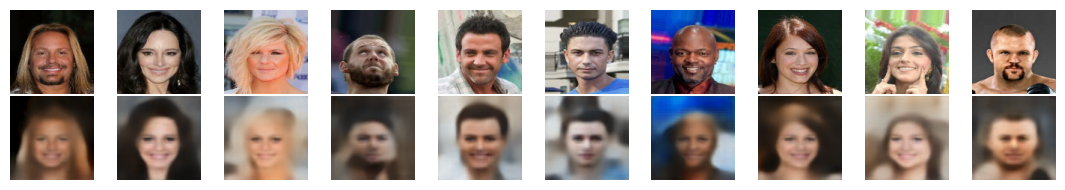

In [9]:
images, labels = next(iter(ds_train))
vae.load_weights(model_path)
outputs = vae(images)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize = (grid_col*1.1, grid_row))
i = 0

for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i])
        axarr[row+1,col].axis('off')
        i += 1
f.tight_layout(h_pad=0.2, w_pad=0.1)
plt.show()


It is promising ! We now can see that our model can reconstruct the original images to some extent. One small thing you might mention is that most of reconstructed images seem to be woman. This phenomenon might be caused by the bias in our training data set

# Generate faces from random data

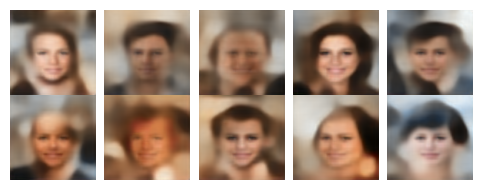

In [10]:
k = 10
z_dim = 200
z_sample = tf.cast(tf.random.normal(shape = (k, z_dim), mean = 0, stddev = 1), tf.float32)
images = vae.decoder(z_sample)

grid_col, grid_row = 5, 2
f, axarr = plt.subplots(grid_row, grid_col, figsize = (grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(h_pad=0.2, w_pad=0.1)
plt.show()

Looks like our constructed images are horrible. It is super blurred and some images you can't even see it as a face or not. But, the previous section we deal with MNIST dataset, our pipeline works quite well. What happen? The problem here might be caused by the range of latent space that we sample. Random sampling withou prior knowledge about the latent space is horrible for both model and us.

To tackle this, I will put again a bunch of images through encoder and figure out the properties of latent space. We hope with sampling `z` correctly, the images should be better.

In [77]:
z_mean = []
z_std = []
steps_per_epoch = train_num//batch_size
# use only one epoch to estimate the z properties
for i in range(steps_per_epoch):
  images, _ = next(iter(ds_train))
  z, means, logvars = vae.encoder(images)
  z_mean.append(tf.reduce_mean(means, axis = 0))
  z_std.append(tf.reduce_mean(tf.exp(0.5*logvars), axis = 0))

avg_z_mean = tf.reduce_mean(z_mean, axis = 0)
avg_z_std = tf.reduce_mean(z_std, axis = 0)

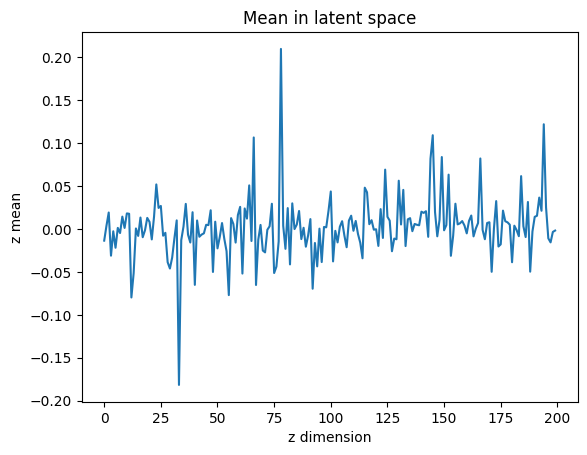

In [78]:
plt.plot(avg_z_mean)
plt.xlabel("z dimension")
plt.ylabel("z mean")
plt.title("Mean in latent space")
plt.show()

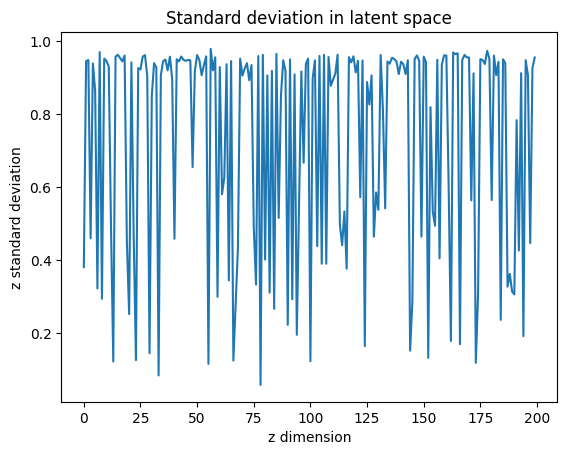

In [79]:
plt.plot(avg_z_std)
plt.xlabel("z dimension")
plt.ylabel("z standard deviation")
plt.title("Standard deviation in latent space")
plt.show()

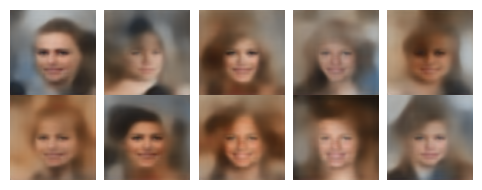

In [80]:
# generate images from random data scaled from true z
z_samples = np.random.normal(loc = np.mean(avg_z_mean), scale = np.mean(avg_z_std), size = (10, z_dim))

images = vae.decoder(z_samples)

grid_col, grid_row = 5, 2
f, axarr = plt.subplots(grid_row, grid_col, figsize = (grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(h_pad=0.2, w_pad=0.1)
plt.show()

Interesting, constructed faces seem to be sharper and more focusing on the faces. The background is still blurry since our training set has diversity of background

# Controlling face attributes

Everything we have done in this section serves only one purpose: to prepare us for __face editing__! This is the climax for this notebook

## Latent space arithmetic
In our FaceVAE, it is a vector of 200 dimensions, or simply 200 variables. As much as we hope each variable has a distinctive semantic meaning to us, such as $z[0]$ for eyes, $z[1]$ for smiling, and so on. We will simply have to assume the information is encoded in all the latent vectors and we can use vector arithmetic to explore the space

Before diving into high-dimensional space, let's try to understand it using a two-dimensional example. Imagine you are now at point $(0,0)$ on a map and your home is at $(x, y)$. Therefore, the direction toward your home is $(x-0, y-0)$ divided by the L2 norm of $(x, y)$., says $(x_0, y_0)$ Therefore, whenever you move $\alpha (x_0, y_0)$ you get closer or further from your house. Similarly, if you want your face get closer to "smiling" position in latent space, the following procedure should be conducted:

`new_z_samples = z_samples + smiling_steps*simling_vector`

## Finding attribute vectors
The assumption is that in latent space, each attribute should lies arround some specific regions (imagine as countries in world map) and we can find those regions from images with their attributes. The idea is simple:
1. Use the test dataset or a few thousand samples from training dataset and use the VAE encoder to generate latent vectors
2. Separate the latent vectores into two groups: with (positive) or without (negative) the one attribute we are interested in
3. Calculate the average of the positive vectors and negative vectors separately
4. Obtain the attribute direction vector by subtracting positive vector to negative one. Then we will have a "path" to get closer to positive or further away from it.

In [81]:
(ds_train, ds_test_), ds_info = tfds.load('celeb_a',
                              split=['train', 'test'],
                              shuffle_files=True,
                              with_info=True)

ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(batch_size*4)
ds_train = ds_train.batch(batch_size).prefetch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).prefetch(batch_size)

In [21]:
def preprocess_attribute(sample, attribute):
  image = sample['image']
  image = tf.cast(image, tf.float32) / 255.
  image = tf.image.resize(image, [112, 112])
  return image, sample['attributes'][attribute]

def extract_attribute_vec(ds, attribute):
  batch_size = 128
  ds = ds.map(lambda x: preprocess_attribute(x, attribute))
  ds = ds.batch(batch_size)
  steps_per_epoch = int(test_num / batch_size)

  pos_z = []
  neg_z = []
  pos_z_num = []
  neg_z_num = []

  for _ in range(steps_per_epoch):
    images, labels = next(iter(ds))
    z, z_means, z_logvars = vae.encoder(images)
    pos_in_step = z[labels == True]
    pos_z.append(np.mean(pos_in_step, axis = 0))
    pos_z_num.append(pos_in_step.shape[0])

    neg_in_step = z[labels == False]
    neg_z.append(np.mean(neg_in_step, axis = 0))
    neg_z_num.append(neg_in_step.shape[0])

  pos_vector = np.average(pos_z, axis = 0, weights = pos_z_num)
  neg_vector = np.average(neg_z, axis = 0, weights = neg_z_num)
  attribute_vector = pos_vector - neg_vector

  return attribute_vector

In [22]:
attributes = list(ds_info.features['attributes'].keys())
attribs_vectors = {}
for attrib in attributes:
    print(attrib)
    attribs_vectors[attrib] = extract_attribute_vec(ds_test, attrib)


5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [59]:
def editing_with_attribute(image, attribute):
  nrows = 1
  ncols = 8
  f, axarr = plt.subplots(nrows, ncols, figsize = (ncols, nrows))

  z_sample, _, _ = vae.encoder(image) # latent vector
  attribute_vector = attribs_vectors[attribute]

  step = -3
  image = np.squeeze(image.numpy())
  axarr[0].imshow(image)
  axarr[0].axis("off")
  for col in range(1, ncols):
    new_z_sample = z_sample + step*attribute_vector
    new_image = vae.decoder(new_z_sample)
    new_image = np.squeeze(new_image.numpy())
    axarr[col].imshow(new_image)
    axarr[col].axis("off")

    step += 1
  f.tight_layout(h_pad = 0.2, w_pad = 0.1)
  plt.show()

In [82]:
images, labels = next(iter(ds_test))

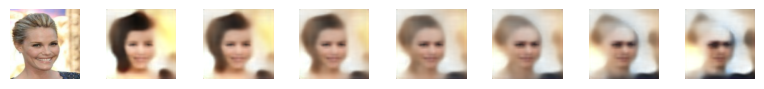

In [88]:
image = tf.reshape(images[4], shape = (1, 112, 112, 3))
editing_with_attribute(image, "Eyeglasses")

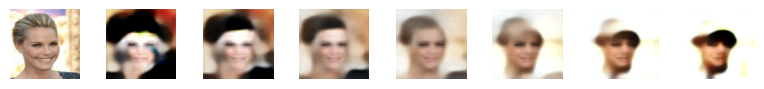

In [89]:
editing_with_attribute(image, "Wearing_Hat")

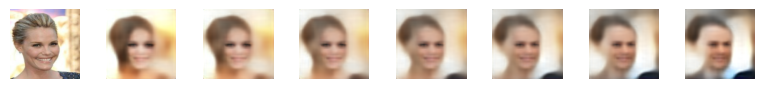

In [90]:
editing_with_attribute(image, "Male")

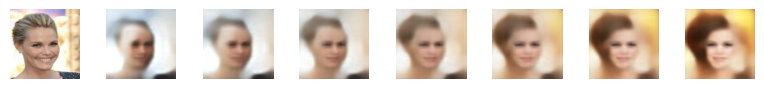

In [91]:
editing_with_attribute(image, "Wavy_Hair")